# 0. Configuration

In [3]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1i6kmeJIUNJjqAa0vAvztFSDN3BFz9x1i/view?usp=sharing'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/12a80lS3vXQOl6i6ENgz-WqWw3Wms0nqB/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MwPaye0cRi53czLqCnH0bOuvIhOeNlAx/view?usp=share_link'

# 1. Modules and functions

In [4]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
# warnings.filterwarnings('ignore')

# pd.set_option('display.float_format', lambda x: '%.3f' % x)

LightFM was compiled without OpenMP support. Only a single thread will be used.


## 1. 1. Helper functions to avoid copy paste

In [5]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [13]:
# interactions data
interactions = pd.read_parquet('/Users/vydolga/Downloads/interactions.parquet', engine = 'pyarrow')
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [14]:
# information about films etc
movies_metadata = read_csv_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [15]:
users_data = read_csv_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [16]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [17]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [18]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [19]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [20]:
interactions_filtered

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,864613,7638,2021-07-05,14483,100.0
3,964868,9506,2021-04-30,6725,100.0
4,1032142,6686,2021-05-13,11286,100.0
...,...,...,...,...,...
4195684,786732,4880,2021-05-12,753,0.0
4195685,546862,9673,2021-04-13,2308,49.0
4195686,697262,15297,2021-08-20,18307,63.0
4195687,384202,16197,2021-04-19,6203,100.0


In [2]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

NameError: name 'MAX_DATE' is not defined

In [22]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3530674, 5) (665015, 5)


In [23]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-11 00:00:00


In [24]:
global_train = global_train.dropna().reset_index(drop = True)

In [25]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5) (1079183, 5)


In [26]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


In [27]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [28]:
dataset

In [29]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [30]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [31]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [32]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [33]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [34]:
display(interactions_filtered['item_id'].unique)

<bound method Series.unique of 0           9506
1           1659
2           7638
3           9506
4           6686
           ...  
4195684     4880
4195685     9673
4195686    15297
4195687    16197
4195688     4436
Name: item_id, Length: 4195689, dtype: int64>

In [35]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [36]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [37]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [38]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [39]:
# execute training
for _ in tqdm(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


In [40]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [41]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13006

In [42]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 2.2222135,  1.4464369, -1.9280975, ..., -2.1294303, -1.9549031,
        -2.0654202], dtype=float32),
 (13006,))

In [43]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 87,   5, 298, 506, 435, 302,  20, 168, 146, 675])

In [44]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [45]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,87,16166,Зверополис
1,5,7571,100% волк
2,298,13915,Вперёд
3,506,10761,Моана
4,435,13018,Король лев (2019)
5,302,12173,Мстители: Финал
6,20,7626,Мстители: Война бесконечности
7,168,3182,Ральф против Интернета
8,146,11310,Аладдин
9,675,13159,Рататуй


In [46]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 869219, row number in matrix - 675


In [47]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-0.19702657, -0.38245714, -2.658608  , ..., -3.2753859 ,
        -3.0609252 , -2.8367202 ], dtype=float32),
 (13006,))

In [48]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 222,  682,   52,  207,  962,  333, 2935, 2059,  306, 5235])

In [49]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,222,676,Человек-невидимка
1,682,16361,Doom: Аннигиляция
2,52,2647,Идеальный пациент
3,207,11143,На пятьдесят оттенков темнее
4,962,9335,Подводная братва
5,333,4141,Пятьдесят оттенков серого
6,2935,1090,Нерождённый
7,2059,10647,"Винчестер. Дом, который построили призраки"
8,306,9169,Взаперти
9,5235,13948,Смерть ей к лицу


In [50]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

144739

In [51]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [52]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [53]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [54]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [55]:
test_preds

,user_id,item_id
0,646903,"[10440, 14741, 16361, 9728, 9169, 13865, 14431..."
1,215229,"[13865, 9728, 10440, 3734, 15297, 4880, 4151, ..."
2,81786,"[15297, 10440, 4151, 2657, 3734, 9728, 13865, ..."
3,985101,"[10440, 15297, 13865, 4151, 9728, 3734, 2657, ..."
4,205710,"[9728, 4436, 13915, 7571, 16166, 3182, 7626, 1..."
...,...,...
144734,800346,"[10440, 15297, 13865, 4151, 9728, 3734, 2657, ..."
144735,247657,"[10440, 15297, 13865, 4151, 9728, 3734, 2657, ..."
144736,673254,"[15297, 10440, 4151, 13865, 4260, 9728, 3734, ..."
144737,114918,"[10440, 13865, 15297, 2657, 9728, 4880, 4151, ..."


In [56]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1447390, 2)

In [57]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [58]:
test_preds.head()

,user_id,item_id,rank
0,646903,10440,1
0,646903,14741,2
0,646903,16361,3
0,646903,9728,4
0,646903,9169,5


In [59]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head(30)

,user_id,item_id,rank,item_name
0,646903,10440,1,Хрустальный
0,646903,14741,2,Цвет из иных миров
0,646903,16361,3,Doom: Аннигиляция
0,646903,9728,4,Гнев человеческий
0,646903,9169,5,Взаперти
0,646903,13865,6,Девятаев
0,646903,14431,7,Приворот. Чёрное венчание
0,646903,14359,8,Проклятие ведьмы
0,646903,5287,9,Брешь
0,646903,1287,10,Терминатор: Тёмные судьбы


In [60]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1739

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [61]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77563, 8)

In [62]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(273965, 8)

In [63]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [64]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [65]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [66]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:             user_id           rank     total_dur   watched_pct         target
count  2.810400e+05  281040.000000  6.186200e+04  61862.000000  281040.000000
mean   5.494367e+05       5.293005  1.860190e+04     65.297727       0.220118
std    3.166136e+05       2.884938  3.902798e+04     36.847643       0.414327
min    1.100000e+01       1.000000  3.010000e+02      0.000000       0.000000
25%    2.751300e+05       3.000000  4.006250e+03     25.000000       0.000000
50%    5.496500e+05       5.000000  7.802000e+03     80.000000       0.000000
75%    8.239755e+05       8.000000  2.266775e+04    100.000000       0.000000
max    1.097528e+06      10.000000  3.127021e+06    100.000000       1.000000 
, TEST:             user_id          rank     total_dur   watched_pct        target
count  7.048800e+04  70488.000000  1.570100e+04  15701.000000  70488.000000
mean   5.470409e+05      5.287794  1.921161e+04     64.979492      0.222747
std    3.170130e+05      2.885783  3.789257e+04     36

In [67]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [68]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [69]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [70]:
print(cbm_train_set.shape, cbm_test_set.shape)

(281040, 16) (70488, 16)


In [71]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,885473,13865,3,Девятаев,NaT,NaN,NaN,0,age_35_44,income_20_40,М,0.0,film,2021.0,NaN,12.0
1,995779,142,3,Маша,NaT,NaN,NaN,0,age_35_44,income_20_40,Ж,1.0,film,2020.0,NaN,16.0
2,908959,14431,10,Приворот. Чёрное венчание,NaT,NaN,NaN,0,age_65_inf,income_20_40,М,0.0,film,2021.0,NaN,16.0
3,159853,12995,7,Восемь сотен,2021-08-06,819.0,9.0,1,age_25_34,income_20_40,Ж,0.0,film,2020.0,NaN,18.0
4,468637,7626,5,Мстители: Война бесконечности,NaT,NaN,NaN,0,age_35_44,income_20_40,М,1.0,film,2018.0,NaN,16.0


In [72]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [73]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(281040, 9) (70488, 9)


In [74]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,3,age_35_44,income_20_40,М,0.0,film,2021.0,NaN,12.0
1,3,age_35_44,income_20_40,Ж,1.0,film,2020.0,NaN,16.0
2,10,age_65_inf,income_20_40,М,0.0,film,2021.0,NaN,16.0
3,7,age_25_34,income_20_40,Ж,0.0,film,2020.0,NaN,18.0
4,5,age_35_44,income_20_40,М,1.0,film,2018.0,NaN,16.0


In [75]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [76]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [77]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6506261	test: 0.6511166	best: 0.6511166 (0)	total: 190ms	remaining: 15m 49s
1:	learn: 0.6177387	test: 0.6185989	best: 0.6185989 (1)	total: 254ms	remaining: 10m 34s
2:	learn: 0.5920360	test: 0.5932559	best: 0.5932559 (2)	total: 312ms	remaining: 8m 40s
3:	learn: 0.5711390	test: 0.5727243	best: 0.5727243 (3)	total: 398ms	remaining: 8m 17s
4:	learn: 0.5546900	test: 0.5565884	best: 0.5565884 (4)	total: 487ms	remaining: 8m 6s
5:	learn: 0.5417376	test: 0.5439034	best: 0.5439034 (5)	total: 569ms	remaining: 7m 53s
6:	learn: 0.5328398	test: 0.5352607	best: 0.5352607 (6)	total: 654ms	remaining: 7m 46s
7:	learn: 0.5248394	test: 0.5275009	best: 0.5275009 (7)	total: 731ms	remaining: 7m 36s
8:	learn: 0.5186023	test: 0.5214660	best: 0.5214660 (8)	total: 802ms	remaining: 7m 24s
9:	learn: 0.5139162	test: 0.5169973	best: 0.5169973 (9)	total: 866ms	remaining: 7m 12s
10:	learn: 0.5096024	test: 0.5128958	best: 0.5128958 (10)	total: 923ms	remaining: 6m 58s
11:	learn: 0.5066625	test: 0.5101224	bes

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [78]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

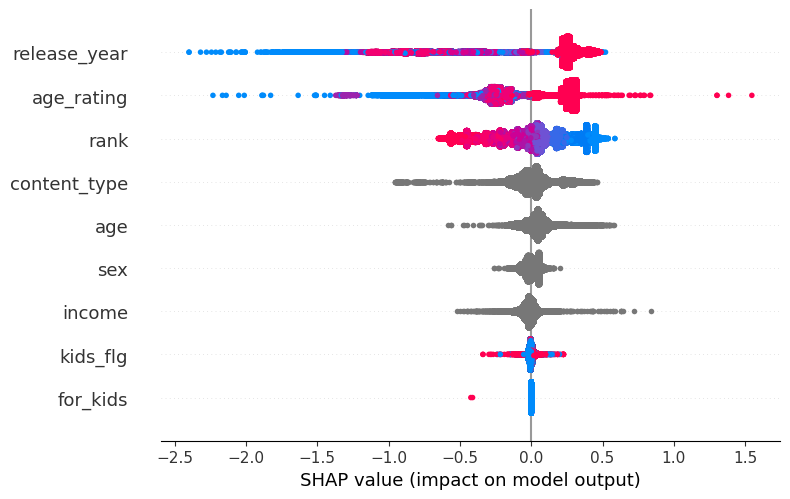

In [79]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [80]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [81]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

In [82]:
def precission_at_k(y_true: np.array, y_pred: np.array, k: int) -> float:
    """
    y_true: true labels
    y_pred: predicted lables
    k: cutoff length
    """

    if sum(y_true) == 0:
        return -1

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    true_positives = y_true_sorted[:k].sum()

    return true_positives / k

In [83]:
def reciprocal_rank(y_true: np.array, y_pred: np.array) -> float:
    
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    for i, val in enumerate(y_true_sorted, 1):     
        if val == 1:
            return 1 / i
    return 0

In [84]:
def average_precision(y_true: np.array, y_pred: np.array, k: int) -> float:

    if sum(y_true) == 0:
        return -1

    if len(y_pred) > k:
        y_pred = y_pred[:k]

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    num_hits = 0
    score = 0

    for i, p in enumerate(y_true_sorted, 1):
        if p == 1:
            num_hits += 1
            score += num_hits / i
    if num_hits == 0:
        output = 0
    
    else:
        output = score / min(len(y_true), k)

    return output

In [85]:
y_pred = test_preds.groupby('user_id')['rank'].apply(lambda x: np.array(x))
y_true = pd.merge(test_preds, interactions, how = 'left', on = ['user_id', 'item_id'])
y_true['last_watch_dt'] = y_true['last_watch_dt'].fillna(0)
y_true['y_true'] = y_true['last_watch_dt'].apply(lambda x: 1 if x!=0 else 0)
y_true = y_true.groupby('user_id')['y_true'].apply(lambda x: np.array(x))

Evaluating LightFm without ranking

In [86]:
x = []
for v, i in zip(y_true, y_pred):
    x.append(precission_at_k(v,i,5))
mean = np.mean(x)
print(mean)   

0.1360766621297646


In [87]:
x = []
for true, pred in zip(y_true, y_pred):
    x.append(average_precision(true, pred, 10))
mean = np.mean(ap_10)
print(mean)

NameError: name 'ap_10' is not defined

In [ ]:
x = []
for true, pred in zip(y_true, y_pred):
    x.append(reciprocal_rank(true, pred))
mean = np.mean(x)
print(mean)

With Ranker

In [ ]:
cbm_test_set['pred'] = y_test_pred[:,1]

In [ ]:
y_pred = cbm_test_set.groupby('user_id')['pred']
y_pred = y_pred.apply(lambda x: np.array(x))
y_true = cbm_test_set.groupby('user_id')['target']
y_true = y_true.apply(lambda x: np.array(x))

In [ ]:
x = []
for v, i  in zip(y_true, y_pred):
    x.append(precission_at_k(v, i, 10))
mean = np.mean(x)
mean

In [ ]:
x = []
for v, i in zip(y_true, y_pred):
    x.append(average_precision(v, i, 10))
mean = np.mean(x)
print(mean)

In [ ]:
x = []
for v, i in zip(y_true, y_pred):
    x.append(reciprocal_rank(v, i))
mean = np.mean(x)
print(mean)
